<a href="https://colab.research.google.com/github/Exper626/EdgeAI_CW/blob/main/training/Copy_of_Final_Training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#final
from IPython.display import Audio

In [ ]:
#!pip install -q "tensorflow_hub==0.13.*"

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.6/100.6 kB 4.8 MB/s eta 0:00:00


In [ ]:
import tensorflow_hub as hub

In [ ]:

# Install required packages
!pip install tensorflow_io librosa

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython import display
import tensorflow as tf
import tensorflow_hub as hub
import librosa
from google.colab import drive
import tensorflow_io as tfio

# Mount Google Drive to access speech files
drive.mount('/content/drive')

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 MB 11.0 MB/s eta 0:00:00


/usr/local/lib/python3.11/dist-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/usr/local/lib/python3.11/dist-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/usr/local/lib/python3.11/dist-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl8str_util8EndsWithESt17basic_string_viewIcSt11char_traitsIcEES4_']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/usr/local/lib/python3.11/dist-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/usr/local/lib/python3.11/dist-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/usr/local/lib/python3.11/dist-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZN3tsl8str_util9LowercaseB5cxx11ESt17basic_s

Mounted at /content/drive


In [ ]:
import librosa
import soundfile as sf

In [ ]:
# YAMNet model for audio feature extraction
yamnet_model_handle = 'https://tfhub.dev/google/yamnet/1'
yamnet_model = hub.load(yamnet_model_handle)


In [ ]:
# Define audio loading function
def load_wav_16k_mono(filename):
    """Load a WAV file, convert it to a float tensor, resample to 16 kHz single-channel audio."""
    file_contents = tf.io.read_file(filename)
    wav, sample_rate = tf.audio.decode_wav(file_contents, desired_channels=1)
    wav = tf.squeeze(wav, axis=-1)  # shape: (samples,)

    def true_fn(): return wav

    def false_fn():
        wav_len = tf.cast(tf.shape(wav)[0], tf.float32)
        sr = tf.cast(sample_rate, tf.float32)
        desired_length = tf.cast(wav_len * 16000.0 / sr, tf.int32)
        return tf.image.resize(wav[tf.newaxis, :, tf.newaxis], [desired_length, 1])[0, :, 0]

    wav = tf.cond(sample_rate == 16000, true_fn, false_fn)
    return wav

In [ ]:
# Download ESC-50 dataset
_ = tf.keras.utils.get_file('esc-50.zip',
                        'https://github.com/karoldvl/ESC-50/archive/master.zip',
                        cache_dir='./',
                        cache_subdir='datasets',
                        extract=True)

645693440/Unknown 40s 0us/step

In [ ]:

esc50_csv = './datasets/esc-50_extracted/ESC-50-master/meta/esc50.csv'
base_data_path = './datasets/esc-50_extracted/ESC-50-master/audio/'

pd_data = pd.read_csv(esc50_csv)


In [ ]:
pd_data.head()

,filename,fold,target,category,esc10,src_file,take
0,1-100032-A-0.wav,1,0,dog,True,100032,A
1,1-100038-A-14.wav,1,14,chirping_birds,False,100038,A
2,1-100210-A-36.wav,1,36,vacuum_cleaner,False,100210,A
3,1-100210-B-36.wav,1,36,vacuum_cleaner,False,100210,B
4,1-101296-A-19.wav,1,19,thunderstorm,False,101296,A


### **Fromn Here**

In [ ]:
# Define our classes (without silence for training)
my_classes = ['vacuum_cleaner', 'door_wood_knock', 'footsteps', 'coughing', 'laughing','keyboard_typing','clock_alarm', 'speech']

# Map ESC-50 categories to our class IDs
esc50_to_our_classes = {
    'vacuum_cleaner': 0,  # category id 36
    'door_wood_knock': 1, # category id 30
    'footsteps': 2,       # category id 25
    'coughing': 3,        # category id 24
    'laughing': 4,        # category id 26
    'keyboard_typing': 5, # c
    'clock_alarm': 6,     # c
    'speech': 7           # Our custom speech files
}

In [ ]:

# Create a dataframe from ESC-50 with only our target classes (excluding speech)
esc_classes = list(esc50_to_our_classes.keys())
esc_classes.remove('speech')  # We'll add speech files separately
filtered_pd = pd_data[pd_data.category.isin(esc_classes)]

# Map class names to our IDs
class_id = filtered_pd['category'].apply(lambda name: esc50_to_our_classes[name])
filtered_pd = filtered_pd.assign(target=class_id)

# Add full paths to the filenames
full_path = filtered_pd['filename'].apply(lambda row: os.path.join(base_data_path, row))
filtered_pd = filtered_pd.assign(filename=full_path)

In [ ]:

# Now prepare speech data from Google Drive
speech_folder = '/content/drive/My Drive/Edge Ai Test/Noise Classify/datasets/speech'
speech_files = [os.path.join(speech_folder, f) for f in os.listdir(speech_folder) if f.startswith('speech_')]


In [ ]:
Audio(speech_files[0])

In [ ]:
print(speech_files[0])

/content/drive/My Drive/Edge Ai Test/Noise Classify/datasets/speech/speech_01.wav


In [ ]:
speech_files

['/content/drive/My Drive/Edge Ai Test/Noise Classify/datasets/speech/speech_01.wav',
 '/content/drive/My Drive/Edge Ai Test/Noise Classify/datasets/speech/speech_02.wav',
 '/content/drive/My Drive/Edge Ai Test/Noise Classify/datasets/speech/speech_03.wav',
 '/content/drive/My Drive/Edge Ai Test/Noise Classify/datasets/speech/speech_04.wav',
 '/content/drive/My Drive/Edge Ai Test/Noise Classify/datasets/speech/speech_05.wav',
 '/content/drive/My Drive/Edge Ai Test/Noise Classify/datasets/speech/speech_06.wav',
 '/content/drive/My Drive/Edge Ai Test/Noise Classify/datasets/speech/speech_07.wav',
 '/content/drive/My Drive/Edge Ai Test/Noise Classify/datasets/speech/speech_08.wav',
 '/content/drive/My Drive/Edge Ai Test/Noise Classify/datasets/speech/speech_09.wav',
 '/content/drive/My Drive/Edge Ai Test/Noise Classify/datasets/speech/speech_10.wav',
 '/content/drive/My Drive/Edge Ai Test/Noise Classify/datasets/speech/speech_11.wav',
 '/content/drive/My Drive/Edge Ai Test/Noise Classify/

In [ ]:
# Load audio, resample to 16kHz, convert to mono
y, sr = librosa.load(speech_files[0], sr=16000, mono=True)
# Save as 16-bit WAV
sf.write("speech_01_audioset.wav", y, sr, subtype='PCM_16')

In [ ]:
Audio('/content/speech_01_audioset.wav')

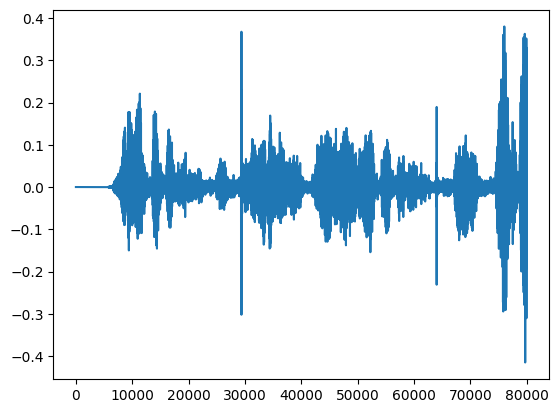

In [ ]:
testing_wav_data = load_wav_16k_mono('/content/speech_01_audioset.wav')

_ = plt.plot(testing_wav_data)

# Play the audio file.
display.Audio(testing_wav_data, rate=16000)

In [ ]:
#converting wav files to audioset dataset auio format
# Output directory (create if it doesn't exist)
output_dir = "converted_audioset_files"
os.makedirs(output_dir, exist_ok=True)

for file_path in speech_files:
    try:
        # Extract the base filename (without extension)
        filename = os.path.splitext(os.path.basename(file_path))[0]

        # Load audio, resample to 16kHz, convert to mono
        y, sr = librosa.load(file_path, sr=16000, mono=True)

        # Save as 16-bit WAV in the output folder
        output_path = os.path.join(output_dir, f"{filename}_audioset.wav")
        sf.write(output_path, y, sr, subtype='PCM_16')

        print(f"Converted: {file_path} -> {output_path}")

    except Exception as e:
        print(f"Error processing {file_path}: {e}")

print("Conversion complete!")

Converted: /content/drive/My Drive/Edge Ai Test/Noise Classify/datasets/speech/speech_01.wav -> converted_audioset_files/speech_01_audioset.wav
Converted: /content/drive/My Drive/Edge Ai Test/Noise Classify/datasets/speech/speech_02.wav -> converted_audioset_files/speech_02_audioset.wav
Converted: /content/drive/My Drive/Edge Ai Test/Noise Classify/datasets/speech/speech_03.wav -> converted_audioset_files/speech_03_audioset.wav
Converted: /content/drive/My Drive/Edge Ai Test/Noise Classify/datasets/speech/speech_04.wav -> converted_audioset_files/speech_04_audioset.wav
Converted: /content/drive/My Drive/Edge Ai Test/Noise Classify/datasets/speech/speech_05.wav -> converted_audioset_files/speech_05_audioset.wav
Converted: /content/drive/My Drive/Edge Ai Test/Noise Classify/datasets/speech/speech_06.wav -> converted_audioset_files/speech_06_audioset.wav
Converted: /content/drive/My Drive/Edge Ai Test/Noise Classify/datasets/speech/speech_07.wav -> converted_audioset_files/speech_07_audio

In [ ]:
# Now prepare speech data from Google Drive
speech_folder_con = '/content/converted_audioset_files'
speech_files_con = [os.path.join(speech_folder_con, f) for f in os.listdir(speech_folder_con) if f.startswith('speech_')]


In [ ]:
Audio(speech_files_con[0])

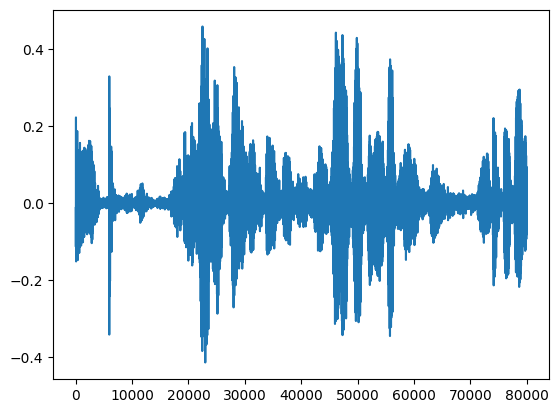

In [ ]:
testing_wav_data = load_wav_16k_mono(speech_files_con[0])

_ = plt.plot(testing_wav_data)

# Play the audio file.
display.Audio(testing_wav_data, rate=16000)

In [ ]:
#testing_wav_file_name = tf.keras.utils.get_file('miaow_16k.wav',
                                                'https://storage.googleapis.com/audioset/miaow_16k.wav',
                                                cache_dir='./',
                                                cache_subdir='test_data')

print(testing_wav_file_name)

215546/215546 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
./test_data/miaow_16k.wav


In [ ]:
# Load audio, resample to 16kHz, convert to mono
#y, sr = librosa.load(speech_test, sr=16000, mono=True)

In [ ]:
#sf.write("speech_01_audioset.wav", y, sr, subtype='PCM_16')

In [ ]:
#Audio("/content/speech_01_audioset.wav")

In [ ]:
#Audio(testing_wav_file_name)

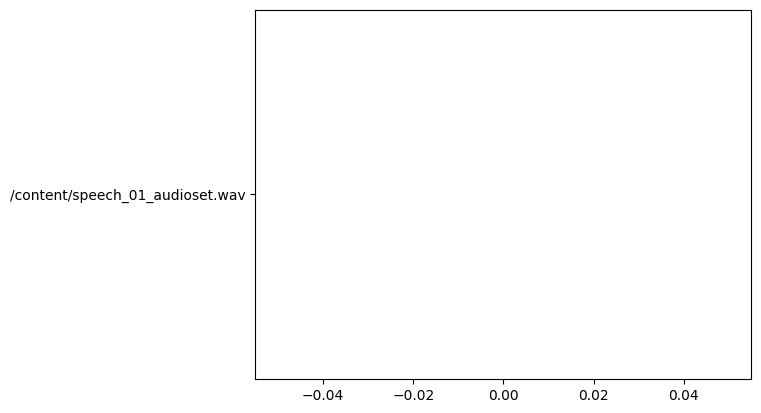

In [ ]:
#_ = plt.plot("/content/speech_01_audioset.wav")

# Play the audio file.
#display.Audio("/content/speech_01_audioset.wav")

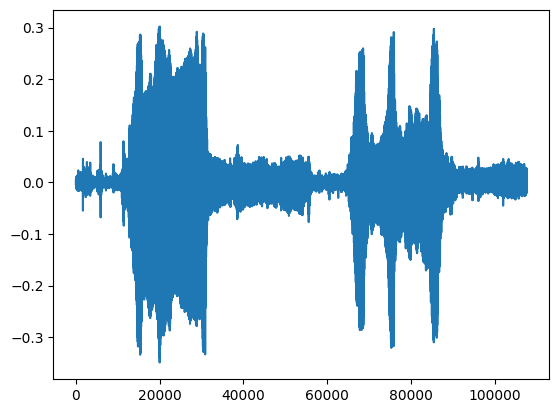

In [ ]:
testing_wav_data = load_wav_16k_mono(testing_wav_file_name)

_ = plt.plot(testing_wav_data)

# Play the audio file.
display.Audio(testing_wav_data, rate=16000)

In [ ]:
# Create a dataframe for speech files
speech_df = pd.DataFrame({
    'filename': speech_files_con,
    'target': [esc50_to_our_classes['speech']] * len(speech_files_con),
    'fold': np.repeat(range(1, 6), 10),
    #'fold': np.random.randint(1, 6, len(speech_files_con)),  # Randomly assign folds
    'category': ['speech'] * len(speech_files_con)  # Set category to 'speech'
})

# Combine ESC-50 and speech dataframes
combined_df = pd.concat([filtered_pd, speech_df], ignore_index=True)

In [ ]:
combined_df

,filename,fold,target,category,esc10,src_file,take
0,./datasets/esc-50_extracted/ESC-50-master/audi...,1,0,vacuum_cleaner,False,100210.0,A
1,./datasets/esc-50_extracted/ESC-50-master/audi...,1,0,vacuum_cleaner,False,100210.0,B
2,./datasets/esc-50_extracted/ESC-50-master/audi...,1,1,door_wood_knock,False,101336.0,A
3,./datasets/esc-50_extracted/ESC-50-master/audi...,1,1,door_wood_knock,False,103995.0,A
4,./datasets/esc-50_extracted/ESC-50-master/audi...,1,1,door_wood_knock,False,103999.0,A
...,...,...,...,...,...,...,...
325,/content/converted_audioset_files/speech_07_au...,5,7,speech,NaN,NaN,NaN
326,/content/converted_audioset_files/speech_48_au...,5,7,speech,NaN,NaN,NaN
327,/content/converted_audioset_files/speech_24_au...,5,7,speech,NaN,NaN,NaN
328,/content/converted_audioset_files/speech_27_au...,5,7,speech,NaN,NaN,NaN


In [ ]:
df2=combined_df[combined_df['fold']==5]

In [ ]:
df2['category'].value_counts()

,count
category,
speech,10
laughing,8
vacuum_cleaner,8
coughing,8
keyboard_typing,8
clock_alarm,8
door_wood_knock,8
footsteps,8


In [ ]:

# Extract filenames, targets, and folds
filenames = combined_df['filename']
targets = combined_df['target']
folds = combined_df['fold']

# Create a TensorFlow dataset
main_ds = tf.data.Dataset.from_tensor_slices((filenames, targets, folds))

In [ ]:
main_ds

<_TensorSliceDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [ ]:
# Function to load audio for mapping
def load_wav_for_map(filename, label, fold):
    return load_wav_16k_mono(filename), label, fold

main_ds = main_ds.map(load_wav_for_map)

In [ ]:
main_ds

<_MapDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [ ]:


# Function to extract embeddings without silence detection during training
def extract_embedding(wav_data, label, fold):
    """Run YAMNet to extract embedding from the wav data"""
    # Extract embeddings
    scores, embeddings, spectrogram = yamnet_model(wav_data)
    num_embeddings = tf.shape(embeddings)[0]

    return (embeddings,
            tf.repeat(label, num_embeddings),
            tf.repeat(fold, num_embeddings))

# Extract embeddings (without silence handling during training)
main_ds = main_ds.map(extract_embedding).unbatch()

In [ ]:

# Cache the dataset for better performance
cached_ds = main_ds.cache()



In [ ]:
cached_ds

<CacheDataset element_spec=(TensorSpec(shape=(1024,), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [ ]:
# Split into train/val/test
train_ds = cached_ds.filter(lambda embedding, label, fold: fold < 4)
val_ds = cached_ds.filter(lambda embedding, label, fold: fold == 4)
test_ds = cached_ds.filter(lambda embedding, label, fold: fold == 5)

# Remove the folds column
remove_fold_column = lambda embedding, label, fold: (embedding, label)
train_ds = train_ds.map(remove_fold_column)
val_ds = val_ds.map(remove_fold_column)
test_ds = test_ds.map(remove_fold_column)

In [ ]:

# Prepare datasets for training
train_ds = train_ds.cache().shuffle(1000).batch(32).prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.cache().batch(32).prefetch(tf.data.AUTOTUNE)
test_ds = test_ds.cache().batch(32).prefetch(tf.data.AUTOTUNE)


In [ ]:
train_ds

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 1024), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

In [ ]:
# Build the model
my_model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(1024,), dtype=tf.float32, name='input_embedding'),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(len(my_classes))  # 6 classes- no silence
], name='my_model')

my_model.summary()

Model: "my_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_9 (Dense)                 │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 8)              │         2,056 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 658,184 (2.51 MB)

 Trainable params: 658,184 (2.51 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Compile the model
my_model.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer="adam",
    metrics=['accuracy']
)

# Train with early stopping
callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)


In [ ]:
# Train the model
history = my_model.fit(
    train_ds,
    epochs=30,
    validation_data=val_ds,
    callbacks=[callback]
)

Epoch 1/30
     15/Unknown 10s 31ms/step - accuracy: 0.5765 - loss: 2.1513

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


15/15 ━━━━━━━━━━━━━━━━━━━━ 10s 74ms/step - accuracy: 0.5813 - loss: 2.1216 - val_accuracy: 0.6923 - val_loss: 0.8201
Epoch 2/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 80ms/step - accuracy: 0.6812 - loss: 0.8857 - val_accuracy: 0.6923 - val_loss: 0.8691
Epoch 3/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7123 - loss: 0.8216 - val_accuracy: 0.6923 - val_loss: 0.7681
Epoch 4/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6639 - loss: 0.9418 - val_accuracy: 0.6923 - val_loss: 0.8107
Epoch 5/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6890 - loss: 0.8368 - val_accuracy: 0.6923 - val_loss: 0.7646
Epoch 6/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6872 - loss: 0.8051 - val_accuracy: 0.6923 - val_loss: 0.7449
Epoch 7/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6697 - loss: 0.7422 - val_accuracy: 0.6923 - val_loss: 0.7805
Epoch 8/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7085 - loss: 0.7406 - val_accuracy: 0.6923 - val_loss: 0.7530


# **New**

In [ ]:
# Evaluate the model
loss, accuracy = my_model.evaluate(test_ds)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.4704 - loss: 1.1754
Test Loss: 0.7001
Test Accuracy: 0.6923


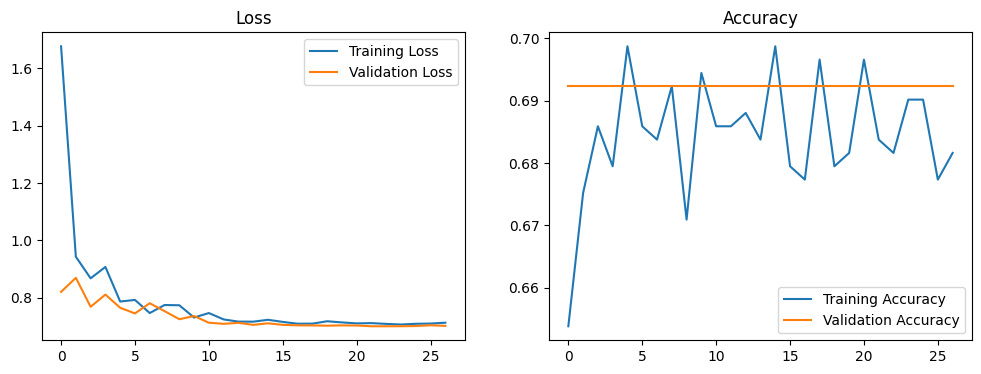

In [ ]:
# Plot training history
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss')

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Accuracy')

plt.show()

In [ ]:
# Define custom layers for the final model
class ReduceMeanLayer(tf.keras.layers.Layer):
    def __init__(self, axis=0, **kwargs):
        super(ReduceMeanLayer, self).__init__(**kwargs)
        self.axis = axis

    def call(self, inputs):
        return tf.reduce_mean(inputs, axis=self.axis)

class YamnetLayer(tf.keras.layers.Layer):
    def __init__(self, model_handle, **kwargs):
        super(YamnetLayer, self).__init__(**kwargs)
        self.yamnet_model = hub.KerasLayer(model_handle, trainable=False)

    def call(self, inputs):
        return self.yamnet_model(inputs)

In [ ]:
# Define silence threshold (for inference only, not used in training)
SILENCE_THRESHOLD = 0.0001

In [ ]:

class SilenceDetectionLayer(tf.keras.layers.Layer):
    def __init__(self, threshold=SILENCE_THRESHOLD, silence_class_index=6, **kwargs):
        super(SilenceDetectionLayer, self).__init__(**kwargs)
        self.threshold = threshold
        self.silence_class_index = silence_class_index

    def call(self, inputs):
        # Calculate the energy of the audio
        audio_energy = tf.reduce_mean(tf.square(inputs))
        # Create a one-hot encoded vector for silence
        batch_size = tf.shape(inputs)[0]
        silence_output = tf.one_hot(tf.ones([batch_size], dtype=tf.int32) * self.silence_class_index,
                                  depth=7)

        # Get the normal model prediction
        scores, embeddings, _ = yamnet_model(inputs)
        model_output = my_model(embeddings)
        model_output = tf.reduce_mean(model_output, axis=0, keepdims=True)
        model_output = tf.nn.softmax(model_output)

        # If energy is below threshold, return silence class, otherwise return model prediction
        return tf.cond(
            tf.less(audio_energy, self.threshold),
            lambda: silence_output,
            lambda: model_output
        )

In [ ]:
# Create and save the final model
input_segment = tf.keras.layers.Input(shape=(), dtype=tf.float32, name='audio')
embedding_extraction_layer = YamnetLayer(yamnet_model_handle, name='yamnet')
_, embeddings_output, _ = embedding_extraction_layer(input_segment)
class_outputs = my_model(embeddings_output)
serving_outputs = ReduceMeanLayer(axis=0, name='classifier')(class_outputs)
serving_outputs = tf.keras.layers.Softmax()(serving_outputs)

In [ ]:
# Create the full model
serving_model = tf.keras.Model(input_segment, serving_outputs)

# First save the classifier model as H5
my_model.save('audio_classifier_test.h5')

In [ ]:

# Function to test the model with a sound file
def predict_sound_class(file_path):
    # Load and preprocess audio
    wav_data = load_wav_16k_mono(file_path)

    # Check for silence
    audio_energy = tf.reduce_mean(tf.square(wav_data))
    if audio_energy < SILENCE_THRESHOLD:
        return 'silence'

    # Extract embeddings
    scores, embeddings, _ = yamnet_model(wav_data)

    # Make prediction
    predictions = my_model(embeddings)
    prediction = tf.reduce_mean(predictions, axis=0)
    class_id = tf.argmax(prediction).numpy()

    return my_classes[class_id]

In [ ]:

# Test the model with a sample file (you can replace this with any file path)

for i in range(100):
  sample_file = combined_df['filename'].iloc[-i]
  predicted_class = predict_sound_class(sample_file)
  print(f"Predicted class for {sample_file}: {predicted_class}")


sample_file = combined_df['filename'].iloc[-2]
predicted_class = predict_sound_class(sample_file)
print(f"Predicted class for {sample_file}: {predicted_class}")

Predicted class for ./datasets/esc-50_extracted/ESC-50-master/audio/1-100210-A-36.wav: coughing
Predicted class for /content/converted_audioset_files/speech_25_audioset.wav: speech
Predicted class for /content/converted_audioset_files/speech_27_audioset.wav: speech
Predicted class for /content/converted_audioset_files/speech_24_audioset.wav: speech
Predicted class for /content/converted_audioset_files/speech_48_audioset.wav: speech
Predicted class for /content/converted_audioset_files/speech_07_audioset.wav: speech
Predicted class for /content/converted_audioset_files/speech_32_audioset.wav: speech
Predicted class for /content/converted_audioset_files/speech_29_audioset.wav: speech
Predicted class for /content/converted_audioset_files/speech_43_audioset.wav: silence
Predicted class for /content/converted_audioset_files/speech_08_audioset.wav: speech
Predicted class for /content/converted_audioset_files/speech_02_audioset.wav: speech
Predicted class for /content/converted_audioset_files

In [ ]:
# Print model summary
print("Model architecture:")
serving_model.summary()

print("Model saved as 'audio_classification_full_model.h5'")
print("Classifier model saved as 'audio_classifier.h5'")
print(f"Available classes: {my_classes}")

Model architecture:


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ audio (InputLayer)              │ (None)                 │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ yamnet (YamnetLayer)            │ [(None, 521), (None,   │             0 │
│                                 │ 1024), (None, 64)]     │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ my_model (Sequential)           │ (None, 8)              │       658,184 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ classifier (ReduceMeanLayer)    │ (8)                    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ softmax (Softmax)               │ (8)                    │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 658,184 (2.51 MB)

 Trainable params: 658,184 (2.51 MB)

 Non-trainable params: 0 (0.00 B)

Model saved as 'audio_classification_full_model.h5'
Classifier model saved as 'audio_classifier.h5'
Available classes: ['vacuum_cleaner', 'door_wood_knock', 'footsteps', 'coughing', 'laughing', 'keyboard_typing', 'clock_alarm', 'speech']
